# Field Goals

In 2013, in the paper Going For Three, the authors undertook predictive modelling of field goal success in the NFL from 2000 to 2011. The study found that several psychological factors had little to no effect on the likelihood of field goal conversion. In 2018, in the paper Choking Under the Pressure, the authors extended the aforementioned study to include data post-2011, up to and including 2017. They found that some of the psychological factors were in fact significant at the 0.1 level.

Neither study looked into the possibility of interactions between the supposedly (independent) variables, which may dilute the observed main effects or even show the effect to be significant. For example, one may reasonably expect that the effect of wind on a kick would increase with distance. Futhermore, in 2015, a rule change saw the extra point distance increased from 20 yards to 33. 20 yard extra point kicks historically average around 99% conversion. The 13 yard increase resulted in a 6% point drop the year of its inception, which continues to this day. As such, we will model only field goals up until 2015, at which time we will then include extra point kicks.

Both studies took a frequentist statistical approach, which although provide frequency guarantees with regards to confidence intervals etc, accept and reject significance of variables at arbitrarly decided values of 0.05 and 0.1. Within Bayesian statistics, by framing parameters as random variables, we are able to give likelihoods of each variable being within some range (credible interval). Arguably more intuitive than the frequentist confidence interval. For small sample sizes, we do forgo some of the frequentist guarantees of confidence intervals, but these concerns disappear for larger samples as the two methods converge asymptotically. With this in mind, we will be using a frequentist approach until the 2015 rule change. The results of this period of time will be used as priors to a Bayesian statistical model which will handle post-rule change data.

This notebook will include exploring the data, validating the results of the earlier papers, and exploring the possibility of interactions. With the most influential interactions, we will use a frequentist approach to the pre-2015 data, and see how our results differ from Going For Three. In the next notebook, we will incorporate these results into the prior distributions for the independent variables and train a model on post-2015 data using MCMC.

## Imports

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm as glm_sm
import numpy as np
import mysql.connector
import itertools
import dtale
from scipy.stats import chi2, pointbiserialr, pearsonr
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt


import sys
sys.path.append('..')
from util.metrics import tetrachoric
from utils.data import clean
from scripts.train import get_data
from util.summary import Summary

## Load Data

Set up a connection to the mysql database served locally.

In [2]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')

We shall first load all the data and inspect it with the d-tale tool or similar pandas functions.

In [ ]:
query = '''select g.seas, avg(f.good) from fgxp f join play p on f.pid=p.pid join game g on g.gid=p.gid where f.fgxp='xp' group by g.seas'''
df_xp = pd.read_sql(query,cnx)
df_xp

In [3]:
where = '''\nand (
(
    fg.fkicker in (select fkicker from fifty) -- has had at least 50 attempts overall (this keeps only kickers that would end up making it in the NFL)
) or    
(
    k.seas>=3  -- or they had played 3 seasons up to the kick (stops removal of kicks from experienced kickers' kicks from early or late in the dataset)
)
)'''

df = get_data(cnx, '< 2015', where=where, base='raw_6_cat')
df.describe()

19715 rows.


,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,,
17,1,43,2000,19,0,0,0,0,0,0,0,1,0,0
34,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
52,1,24,2000,19,0,0,0,0,0,0,0,1,0,0
64,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
95,1,48,2000,19,0,0,0,0,0,0,0,1,0,0
241,1,50,2000,6,0,0,1,0,1,0,1,0,0,0
277,1,25,2000,6,0,0,1,0,1,0,0,0,0,0
375,1,33,2000,3,0,0,0,0,1,0,0,1,0,0
387,1,34,2000,1,0,0,0,0,0,0,0,1,0,0


## Clean

In [ ]:
df = clean(df)
df.drop('FG', axis=1, inplace=True)
df.describe()

## Explore

#### Correlations & Visualisations

We assess the correlations: continuous pairs with Pearsons, continuous-binary with pointbiserial, binary pairs with tetrachoric.

In [4]:
con_vars = ['dist','year','seasons','temperature','wind','pressure']
bin_vars = df.drop(con_vars, axis=1).columns.values

correlations = []

for v1, v2 in itertools.product(bin_vars,bin_vars):
    if v1>v2:
        try:
            correlations.append([v1,v2,tetrachoric(df[v1],df[v2]),None,'tetrachoric'])
        except Exception as e:
            print(e)
            print(f'{v1}-{v2}: NaN')

for b1, c2 in itertools.product(bin_vars,con_vars):
    try:
        correlations.append([b1, c2, pointbiserialr(df[b1],df[c2])[0], pointbiserialr(df[b1],df[c2])[1], 'pointbiserial'])
    except Exception as e:
        print(e)
        print(f'{b1}-{c2}: {e}')

for c1, c2 in itertools.product(con_vars,con_vars):
    if c1>c2:
        try:
            correlations.append([c1, c2, pearsonr(df[c1],df[c2])[0], pearsonr(df[c1],df[c2])[1], 'pearsons'])
        except Exception as e:
           print(f'{c1}-{c2}: {e}')


df_corr = pd.DataFrame.from_records(correlations, columns=['cov 1','cov 2', 'corr', 'p','type'])
df_corr[abs(df_corr['corr'])>0.2].sort_values('corr')


From the table above we can see a few things.
* The strongest correlations belong to the binary variables
* turf and altitude have a strong correlation because there is only one stadium at altitude, Denver, and that stadium has a grass surface.
* Weather conditions are relatively strongly correlated to altitude. Which is a well known in meteorology.
* Precipitation increases humidity, that should be obvious.
* Coaches tend to ice kickers when the game is tight, i.e. pressure situations.
* Age and seasons are strongly related.

In [6]:
sns.pairplot(df.loc[:,con_vars], hue='good')

Not much we can pull from the above scatters, but lets make a few points.
* It looks like as kickers get late into their careers, they take fewer long distance attempts.
* Distance of attempts for each year is relatively stable. Looks like 2008 has a few massively long attempts.
* Seasons only increasings year-on-year because the span isnt long enough to record retirements. So moving on, we'd expect less correlation.

In [ ]:
df_ = df.copy()
df['seas_bin'] = 4*round(df['seasons']/4)
df['temp_bin'] = 4*round(df['temperature']/4)
df['age_bin'] = 4*round(df['age']/4)
df['dist_bin'] = 4*round(df['dist']/4)

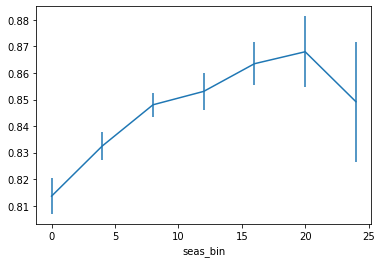

In [7]:
pairs = [('seas_bin',y,'away_game') for y in bin_vars if y!='away_game']
kwargs = lambda z: {x:z[0], y:z[1], hue:z[2], data:df_}
for pair in pairs:
    sns.lineplot(**kwargs(pair))
    plt.title(pair[1])
    plt.show()

In [ ]:
pairs = [('seas_bin', 'good', None),('dist_bin', 'good', None)]
for pair in pairs:
    sns.lineplot(**kwargs(pair))
    plt.title(pair[0])
    plt.show()

## Feature Selection

### Main Effects

In [ ]:
# base result
formula = 'good ~ ' + '+'.join(df.drop(['good'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
print(with_)

#### Multicollinearity

Neither of the aforementioned papers addressed the possibility of multicollinearity, omitted variable bias.

In the LR section, we remove each of the variables one-by-one and assess the changes in expected values and standard errors of coefficients of the remaining variables. Multicollinearity affects the standard errors of correlated variables and reduces stability when present. However, if a variable is correlated to both the dependent and an independent variable but is omitted, the remaining correlated variable exhibits bias (omitted variable bias or OVB).

In the LASSO section, we perform regularised regression on the normalized data and see which variables have non-zero coefficients.

#### Likelihood Ratio Test

We can tabulate the results, showing the change in expected coefficients and std errs when we include/exclude each covariate. A summary of the findings is presented below.

In [20]:
removed = {}
for cov in df.drop(['good'], axis=1).columns.values:
    formula = 'good ~ ' + '+'.join(df.drop(['good',cov], axis=1).columns.values)
    model = glm_sm(formula, df, family=sm.families.Binomial())
    without_ = Summary(model.fit(method='irls'))
    difference, p = with_ - without_
    removed[cov] = {'diff':difference, 'p': p, 'summary': without_}

In [21]:
print('LR test p-values:\n', [(cov,round(d['p'],4)) for cov,d in removed.items()])

LR test p-values:
 [('dist', 0.0), ('year', 0.0), ('seasons', 0.0047), ('cold', 0.0), ('altitude', 0.0008), ('humid', 1.0), ('windy', 0.0034), ('away_game', 1.0), ('postseason', 0.138), ('iced', 0.0736), ('turf', 0.0), ('precipitation', 0.032), ('pressure', 0.3711)]


In [22]:
cov = 'year'
print(f'Results for "{cov}"\n', 'P(LR|Ho): ', removed[cov]['p'])
removed[cov]['diff']

Results for "year""
 P(LR|Ho):  6.378900535848336e-18


,coef with_year,coef w/o_year,% coef,se with_year,se w/o_year,% se,P with_year,P w/o_year
Intercept,-93.9637,6.0754,106.465688,11.649,0.147,98.738089,0.000,0.000
altitude,0.4820,0.4825,-0.103734,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0129,-0.0115,10.852713,0.049,0.049,0.000000,0.794,0.814
cold,-0.3764,-0.3825,-1.620616,0.058,0.058,0.000000,0.000,0.000
dist,-0.1150,-0.1126,2.086957,0.003,0.003,0.000000,0.000,0.000
humid,-0.0081,-0.0292,-260.493827,0.055,0.055,0.000000,0.883,0.595
iced,-0.1349,-0.1296,3.928836,0.074,0.073,1.351351,0.067,0.077
postseason,-0.1836,-0.1976,-7.625272,0.121,0.121,0.000000,0.130,0.102
precipitation,-0.1881,-0.2324,-23.551302,0.087,0.087,0.000000,0.031,0.007
pressure,0.0210,0.0185,11.904762,0.024,0.024,0.000000,0.383,0.440


* dist: OVB on iced and also goes siginificant, OVB with pressure but not significant anyway, maybe OVB with away_game but never significant. LR test rejected null.
* altitude: Sigificant on its own, no real OVB seen elsewhere, apart from humid which wasnt significant anyway. LR test rejected null.
* away_game: No OVB and not siginificant to begin with. LR test did not reject null.
* cold: OVB on postseason (which also became significant w/o cold). Slight OVB with windy. LR test rejected null.
* humid: No change on any covariate estimates. LR test did not reject null.
* iced: OVB on pressure but it never became significant. LR test did not reject null, however it was close.
* postseason: Nothing. LR test did not reject null.
* precipitation: OVB on humidity (theyre correlated), but no changes on significance. LR test rejected null.
* pressure: No change. Not even an OVB on iced. LR test did not reject null.
* seasons: No change. Is significant variable. LR test rejected null.
* turf: OVB on humidity, turf pitches must be in warmer climates. LR test rejected null.
* windy: No change. LR test rejected null.
* year: No change. Slight OVB on seasons as we didnt see too many retirements for 2000-2015. LR test rejected null.

Points:
* cold vs postseason -- postseason is in winter so removing cold resulting in strong OVB on postseason estimate.
* dist vs iced -- Dist is a strong indicator, and iced kicks are slightly longer on average, hence the OVB.
* standard errors not largely different from control to treatment, but OVB seems significant for a few combinations.
* Humidity adds nothing and we see no OVB with its omissions. We'll remove it.


#### LASSO

Regularisation enforces sparsity. So assuming our variables are on the same scale, the largest absolute coefficients should indicate the most important variables.

In [ ]:
from util.features import LASSO

summary = LASSO(df, doubles=False, triples=False)
summary

Clearly distance is the biggest factor, followed by year, altitude, cold, seasons, surface and precipitation. Psychological factors like postseason, iced, pressure, and away_game are less important. Humidity, as was the case in the LR test, is the least important.

### Iteractions

In [ ]:
df.drop(['humid','age'], axis=1, inplace=True)

In [24]:
# base result
formula = 'good ~ ' + '+'.join(df.drop(['good'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
without_ = Summary(result)
print(without_)

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14299
Model:                            GLM   Df Residuals:                    14286
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5294.1
Date:                Fri, 28 Feb 2020   Deviance:                       10588.
Time:                        08:16:48   Pearson chi2:                 1.35e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -94.0453     11.636     -8.082      0.000    -1

#### LASSO
Performing LASSO is one way of finding the most important variables and their interactions. We'll create variables for all the interactions, then bootstrap several times and find the coefficients of the penalised LR model each time.

In [ ]:
covariates = df.drop(['good'], axis=1).columns.values
summary = LASSO(df, covariates, triples=False, drop_post=['age'])
summary

#### Likelihood Ratio Test

We expect to get a whole heap of false positives if we test all interactions. So we only test those from LASSO test.

In [25]:
from util.feature import get_interactions

covariates = ['iced', 'away_game', 'seasons', 'dist', 'temperature', 'precipitation']
interactions = get_interactions(covariates)

inters = {}
for interaction in interactions:
    formula = 'good ~ ' + '+'.join(df.drop(['good'], axis=1)) + '+' + interaction
    model = glm_sm(formula, df, family=sm.families.Binomial())
    with_ = Summary(model.fit(method='irls'))
    diff, p = with_ - without_
    inters[interaction] = [interaction, with_.log_likelihood - without_.log_likelihood, p, diff]

df_inter = pd.DataFrame.from_records(list(inters.values()), columns=['interaction','delta_ll','p', 'diff']).set_index('interaction')
df_inter[df_inter['p']<0.4].sort_values('p', ascending=True).loc[:,['delta_ll','p']]

Pressure\*altitude shows up again. Seasons\*dist is plausible. Windy\*postseason seems like an interaction by proxy (with cold). Seasons\*away_game shows up again. Iced*altitude is spurious. Windy\*cold is plausible. Iced\*away_game is plausible. Precipitation\*dist is plausible. Iced\*cold is plausible.

Now we investigate graphically.

#### Graphically

In [ ]:
df_ = df.copy()
df['seas_bin'] = 4*round(df['seasons']/4)
df['temp_bin'] = 4*round(df['temperature']/4)
df['dist_bin'] = 4*round(df['dist']/4)

In [ ]:
kwargs = lambda z: {x:z[0], y:z[1], hue:z[2], data:df_}
pairs = [('iced', 'good', 'away_game'),
         ('dist_bin', 'good', 'seas_bin'),
         ('temp_bin', 'good', 'precipitation'),
        ]


for pair in pairs:
    sns.lineplot(**kwargs(pair))
    plt.title(pair[0])
    plt.show()

In [44]:
print('P(LR|Ho): ',df_inter.loc['iced*away_game', 'p'])
df_inter.loc['iced*away_game', 'diff']

P(LR|Ho):  1.0


,coef with_pressure:dist,coef w/o_pressure:dist,% coef,se with_pressure:dist,se w/o_pressure:dist,% se,P with_pressure:dist,P w/o_pressure:dist
Intercept,-94.0126,-94.0453,-0.034783,11.638,11.636,0.017185,0.000,0.000
altitude,0.4840,0.4842,-0.041322,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0128,-0.0128,-0.000000,0.049,0.049,0.000000,0.795,0.795
cold,-0.3778,-0.3778,-0.000000,0.057,0.057,0.000000,0.000,0.000
dist,-0.1156,-0.1150,0.519031,0.005,0.003,40.000000,0.000,0.000
iced,-0.1343,-0.1348,-0.372301,0.074,0.074,0.000000,0.068,0.067
postseason,-0.1832,-0.1832,-0.000000,0.121,0.121,0.000000,0.131,0.131
precipitation,-0.1914,-0.1913,0.052247,0.084,0.084,0.000000,0.024,0.024
pressure,0.0020,0.0210,-950.000000,0.120,0.024,80.000000,0.987,0.382
pressure:dist,0.0004,NaN,NaN,0.003,NaN,NaN,0.871,NaN


Points:
* It's tough to separate the effect of postseason games and the cold. There's never a postseason game during the warmer months so maybe we'll have to do an observational study for this. My thoughts are its the cold doing the work, because the OVB when leaving out cold is significant on the postseason coefficient but not other way around. But pressure\*postseason makes more sense than pressure\*cold.

* Choose: seasons\*dist, windy\*cold, iced\*away_game, pressure\*postseason, pressure\*iced.

* I wanted to keep wind\*dist but there was no evidence that supported my hypothesis.


From LASSO:
* iced\*away_game
* windy\*cold

From LR:
* seasons\*dist
* pressure\*iced (not sig)
* pressure\*postseason (not sig)

### Modelling

In [389]:
interactions = '+ seasons*dist + iced*away_game + temperature*precipitation'

In [391]:
# base result without interactions
formula = 'good ~ ' + '+'.join(df.drop(['good'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
base_result = model.fit(method='irls')
without_ = Summary(base_result)
print(without_.result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                12720
Model:                            GLM   Df Residuals:                    12707
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4719.4
Date:                Fri, 28 Feb 2020   Deviance:                       9438.8
Time:                        13:44:33   Pearson chi2:                 1.20e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -94.5215     12.352     -7.652      0.000    -1

In [392]:
formula = 'good ~ ' + '+'.join(df.drop(['good'], axis=1).columns.values) + interactions
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
diff, p = with_ - without_
print(f'P(LR|Ho):{p}\n', f'With interactions:{with_.log_likelihood}\n', f'Without interactions:{without_.log_likelihood}')

P(LR|Ho):0.06196880441665898
 With interactions:-4713.4
 Without interactions:-4719.4


In [393]:
print(with_.result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                12720
Model:                            GLM   Df Residuals:                    12701
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4713.4
Date:                Fri, 28 Feb 2020   Deviance:                       9426.8
Time:                        13:44:35   Pearson chi2:                 1.20e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -92.3734     12.464     -7.41

### Evaluation

In [387]:
from util.evaluation import odds, confusion

In [388]:
sig_coefs = with_.summary['coef'].drop(['windy','pressure','form'])

confusion(['away_game', 'iced'], sig_coefs)
confusion(['cold', 'windy'], sig_coefs)
confusion(['seasons','dist'], sig_coefs)

NameError: name 'np' is not defined

In [ ]:
# odds(**{'seasons':15, 'dist':55})/odds(**{'seasons':0, 'dist':55})
# odds(**{'seasons':15})/odds(**{'seasons':0})
# odds(**{'away_game':0, 'iced':1, 'pressure':6})/odds(**{'away_game':0, 'iced':0, 'pressure':6})
# # odds(**{'pressure':1, 'iced':1})/odds(**{'pressure':1, 'iced':0})
# # odds(**{'pressure':6, 'iced':1})/odds(**{'pressure':6, 'iced':0})

# odds(**{'seasons':1, 'dist':50})/odds(**{'seasons':1, 'dist':49})
# odds(**{'away_game':1, 'iced':0, 'pressure':6})/odds(**{'away_game':0, 'iced':0, 'pressure':6})

We can give some examples of influence.


* Icing an away game kick increases the odds 1.07 times. Weird.
* Icing a home kick, odds are 0.75 times.

* Un-iced, an away kick, odds are 0.91 times.
* Iced, an away kick, odds are 



* For a rookie, every yard added the odds are about 0.9 times.
* However for a veteran of 15 seasons, its gets a bit complicated. Experience matters, but so does the body.
* Over the rookie, at 35 yards (the average kick), the veteran is about 1.5 times more likely to make the kick. If we dont account for distance interacting with the kickers weary old age, this blows out to 3.1 times as likely to convert.
* At 55 yards, a rookie would narrowly pip an experienced 15 season veteran, with the odds ratio dropping to 0.91. Again, not taking the interaction into consideration and "father time" blows out to 3.4 times as likely.


We'll use these values in the next study, which is a Bayesian approach to post-2015 data.

In [394]:
now = dt.now().strftime('%d%m%y')
with_.summary.to_csv(f'fg_results_{now}.csv')

Even though we are interested in accurate inference, let's check the model isn't complete garbage.

In [381]:
from sklearn.metrics import roc_auc_score, roc_curve

In [382]:
y_t = df_test['good']

# base
y_p = base_result.predict(df_test.drop('good',axis=1))
auc_base = roc_auc_score(y_t, y_p)
curve_base = roc_curve(y_t, y_p)
df_base = pd.DataFrame.from_records(np.column_stack(curve_base), columns=['fpr','tpr','thresholds'])
df_base['type'] = 'base'

# interactions
y_p = result.predict(df_test.drop('good',axis=1))
auc = roc_auc_score(y_t, y_p)
curve = roc_curve(y_t, y_p)
df_int = pd.DataFrame.from_records(np.column_stack(curve), columns=['fpr','tpr','thresholds'])
df_int['type'] = 'interactions'

# dummy - good
y_p = [1]*len(df_test)
y_p = pd.Series(y_p)
auc_dg = roc_auc_score(y_t, y_p)
curve_dg = roc_curve(y_t, y_p)
df_dg = pd.DataFrame.from_records(np.column_stack(curve_dg), columns=['fpr','tpr','thresholds'])
df_dg['type'] = 'All good'

# dummy - random @ P(good)
p = df_train['good'].value_counts(normalize=True)[1]
y_p = pd.Series([1 if p>np.random.rand() else 0 for _ in range(len(df_test))])
auc_dp = roc_auc_score(y_t, y_p)
curve_dp = roc_curve(y_t, y_p)
df_dp = pd.DataFrame.from_records(np.column_stack(curve_dp), columns=['fpr','tpr','thresholds'])
df_dp['type'] = 'P(good)'

# dummy - @ dist>40
y_p = df_test['dist']>40
auc_dd = roc_auc_score(y_t, y_p)
curve_dd = roc_curve(y_t, y_p)
df_dd = pd.DataFrame.from_records(np.column_stack(curve_dd), columns=['fpr','tpr','thresholds'])
df_dd['type'] = '@d>40'

In [383]:
aucs = pd.Series([auc_dp, auc_dg, auc_base, auc], index=['@p','good','base','with interactions'])
aucs

@p                   0.496893
good                 0.500000
base                 0.768877
with interactions    0.767791
dtype: float64

Text(0.5, 1.0, 'ROC for each model')

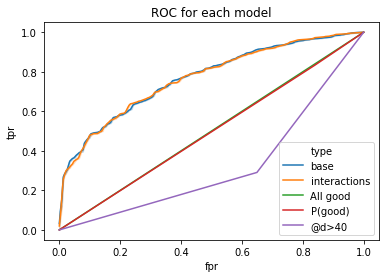

In [384]:
from seaborn import lineplot
df_all = pd.concat([df_base,df_int,df_dg,df_dp,df_dd])
ax = lineplot(x='fpr',y='tpr', data=df_all, hue='type')
ax.set_title('ROC for each model')

Interactions and base model have the same predictive power, but I'd argue the interactions provide more accuracte inference. Both are better than the simplest models.

### See you in the next notebook.